# Local CorEx Tutorial: Understanding Crime Data Patterns

In this tutorial, we will apply **Local CorEx**, an information-theoretic method, to analyze the structure of the crime dataset. Local CorEx is well-suited for detecting higher-order interactions in data and extracting meaningful latent factors. 

### Why Local CorEx?
Many real-world datasets, such as crime data, often contain intricate relationships that traditional clustering methods may miss. Local CorEx helps uncover these hidden relationships by grouping variables based on mutual information, giving us insight into which variables jointly explain the most variation in the data.

In this notebook, we will:
1. Apply PHATE for dimensionality reduction and visualize the data.
2. Use KMeans to partition the dataset into meaningful clusters.
3. Analyze the variables using Local CorEx and plot key relationships.
4. Compare the difference between Local CorEx models across partitions.

By the end of this tutorial, you should have a better understanding of how to use Local CorEx to extract insights from complex datasets.

# Local CorEx Tutorial

## Introduction

Local CorEx is a powerful tool for exploring a dataset. Here we will demonstrate its utility in exploring the crime dataset. We first show how to load and process the data before we begin our analysis.

## Import libraries

In [6]:
import scprep
import phate
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from local_corex import LinearCorex, partition_data
from local_corex.utils import data as du, plotting as pu

## Download & Process Data

We first download the data from https://archive.ics.uci.edu/dataset/183/communities+and+crime and extract it. This results in two files: communities.data and communities.names. communities.data is a csv file that contains our dataset and communities.names contains keys explaining what column names mean and other useful bits of information about the data. We also include a state_dict python dictionary that maps from the coded state number to its two letter representation.

We then read in the data using pandas, replace '?' values with np.nan and only keep rows where there aren't missing data. Finally we drop some of the categorical features like communityname, state, and fold.

In [3]:
'''
The state_dict was created following the data provided at:
https://www.census.gov/library/reference/code-lists/ansi/ansi-codes-for-states.html
'''

state_dict = {1:'AL', 2:'AK', 4:'AZ', 5:'AR', 6:'CA', 8:'CO', 9:'CT', 10:'DE',
            11:'DC', 12:'FL', 13:'GA', 15:'HI', 16:'ID', 17:'IL', 18:'IN', 19:'IA',
            20:'KS', 21:'KY', 22:'LA', 23:'ME', 24:'MD', 25:'MA', 26:'MI', 27:'MN',
            28:'MS', 29:'MO', 30:'MT', 31:'NE', 32:'NV', 33:'NH', 34:'NJ', 35:'NM',
            36:'NY', 37:'NC', 38:'ND', 39:'OH', 40:'OK', 41:'OR', 42:'PA', 44:'RI', 
            45:'SC', 46:'SD', 47:'TN', 48:'TX', 49:'UT', 50:'VT', 51:'VA', 53:'WA',
            54:'WV', 55:'WI', 56:'WY'}

'''
Data downloaded from https://archive.ics.uci.edu/dataset/183/communities+and+crime
and then extracted afterwards
'''

var_names = ['state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize',
            'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
            'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf',
            'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap',
            'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov',
            'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy',
            'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 
            'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par',
            'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg',
            'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig',
            'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 
            'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 
            'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 
            'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded', 'PctVacMore6Mos', 
            'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal',
            'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent', 'MedRentPctHousInc', 
            'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn',
            'PctBornSameState', 'PctSameHouse85', 'PctSameCity85', 'PctSameState85', 'LemasSwornFT',
            'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 
            'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite',
            'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 
            'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars',
            'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
            'PolicBudgPerPop', 'ViolentCrimesPerPop']
data = pd.read_csv('../../data/communities.data', header=None, names=var_names)
data = data.replace('?', np.nan)
crime = data.loc[: , (data.isnull().sum(axis = 0) == 0).tolist()]
crime = crime.drop(['communityname', 'state', 'fold'], axis=1)
crime.shape

(1994, 100)

## Visualize Data

We can now run PHATE to get a 2D embedding of our data.

Calculating PHATE...
  Running PHATE on 1994 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.21 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.22 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 1.83 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.46 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.36 seconds.
Calculated PHATE in 5.89 seconds.


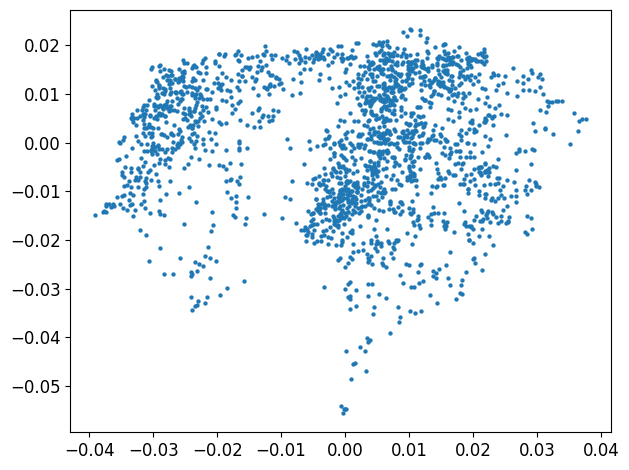

<Axes: >

In [4]:
phate_operator = phate.PHATE(n_components=2, n_jobs=-2, random_state=42)
Y_phate_2d = phate_operator.fit_transform(crime)
scprep.plot.scatter2d(Y_phate_2d)

# Local CorEx

## Partition data into clusters
The first step in Local CorEx is to partition the data into homogenous regions. We accomplish this by creating a 8 dimensional PHATE embedding and then run KMeans clustering on that embedding where we choose k to be 15. This step is accomplished in the first line of code and returns a list of indexes for each cluster and the predicted cluster from KMeans.

The for loop performs some EDA where we count and print the number of communities from each state that reside in a given cluster.

In [7]:
num_clusters = 10
indexes, pred = partition_data(crime, n_partitions=num_clusters, phate_dim=8, n_jobs=-2, seed=42, return_pred=True)

for i in range(0, num_clusters):
    s_mapped = data['state'].map(state_dict, na_action='ignore')
    print("Group number:", i, Counter(s_mapped[indexes[i]]))

Calculating PHATE...
  Running PHATE on 1994 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.14 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.15 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 1.77 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.51 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 282.37 seconds.
Calculated PHATE in 284.81 seconds.
Group number: 0 Counter({'OH': 28, 'TX': 15, 'NY': 14, 'IN': 13, 'MO': 12, 'OK': 12, 'TN': 11, 'OR': 10, 'PA': 10, 'IA': 9, 'AL': 9, 'WI': 9, 'WA': 8, 'KY': 8, 'AR': 8, 'NC': 6, 'WV': 5, 'VA': 5, 'SD': 5, 'NM': 4, 'ND': 4, 'CA': 3, 'ID': 3, 'MA': 3, 'ME': 3, 'NH': 2, 'CO': 2, 'AZ': 1, 'UT': 1, 'VT': 1, 'MS': 1, 'GA': 1, 'FL': 1, 'WY': 1, 'SC': 1, 'MD': 1})
Group number: 1 Counter({'NJ': 51, 'MA': 21, 'CT': 13, 'CA': 

c:\Users\tkerby2\Desktop\Research\Local_CorEx\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\tkerby2\Desktop\Research\Local_CorEx\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\tkerby2\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tkerby2\AppData\Roaming\uv\python\cpython-3.11.13-windows-x86_64-none\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(a

## Visualize Data

Here we color the PHATE embedding by:
* Groups learned from KMeans
* % of people in urban areas 
* median household income
* % of population age 65+

From this, we can see that we have two main clusters in the data. Communities that are mostly urban or rural. We can also see that median household income increases the further up and to the left you go in the embedding space for both rural and urban communities. We can also see to the left of each cluster that there are older populations with younger populations being more dispersed and often to the right in each of the two main clusters.

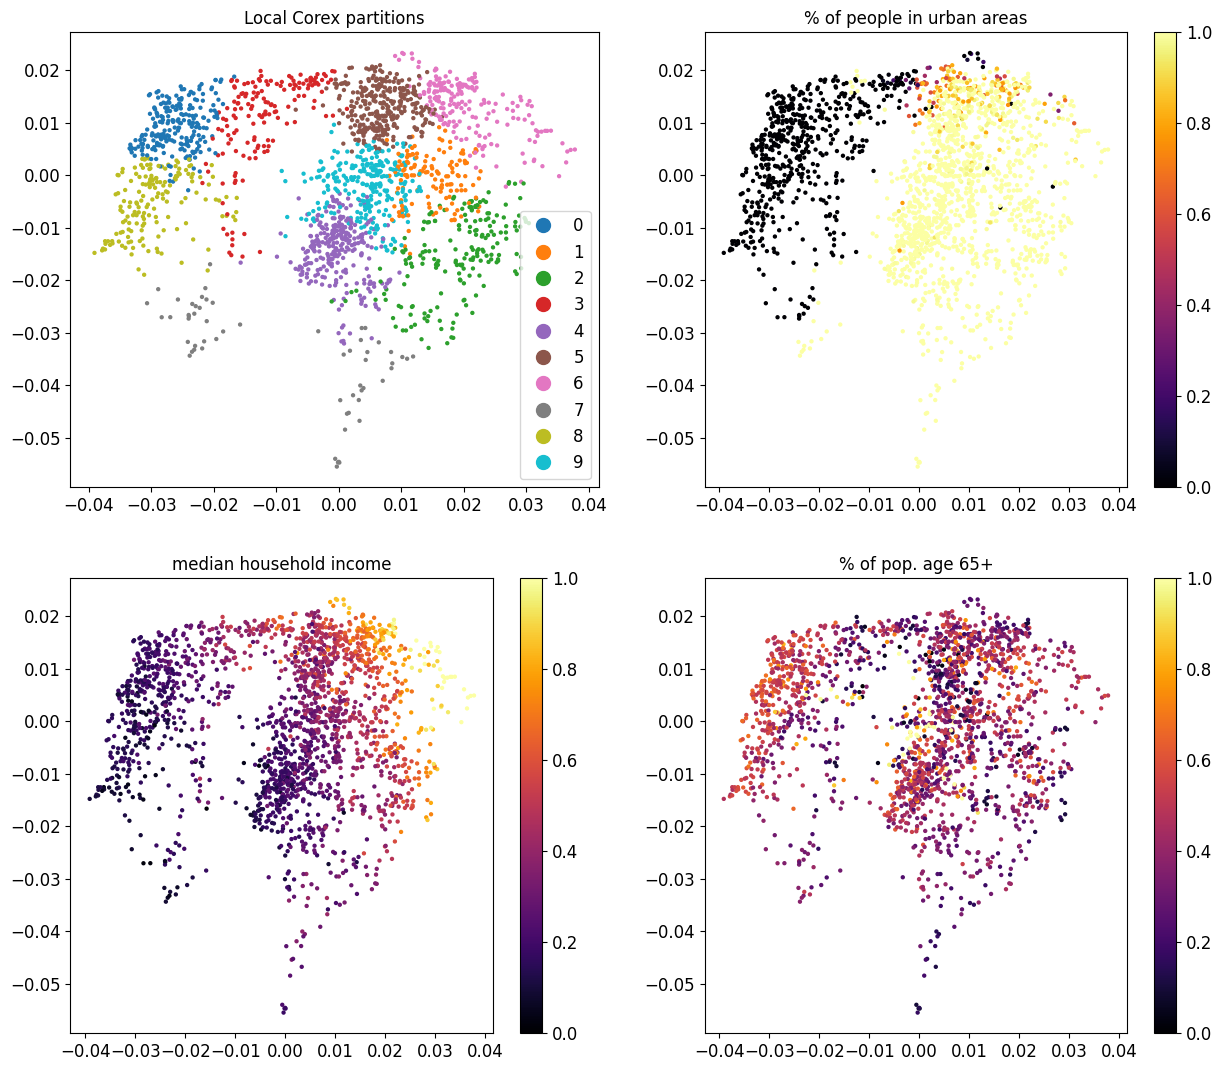

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
scprep.plot.scatter2d(Y_phate_2d, c=pred, ax=axes[0,0])
axes[0,0].set_title("Local Corex partitions")
scprep.plot.scatter2d(Y_phate_2d, c=data['pctUrban'], ax=axes[0,1])
axes[0,1].set_title("% of people in urban areas")
scprep.plot.scatter2d(Y_phate_2d, c=data['medIncome'], ax=axes[1,0])
axes[1,0].set_title("median household income")
scprep.plot.scatter2d(Y_phate_2d, c=data['agePct65up'], ax=axes[1,1])
axes[1,1].set_title("% of pop. age 65+")
plt.show()

### Group 0

In [9]:
du.explore_cluster(crime, indexes[0], 20)

pctUrban           -1.565708
RentHighQ          -0.983365
MedRent            -0.971935
RentMedian         -0.962664
RentLowQ           -0.938643
MedOwnCostPctInc   -0.922469
PctOccupManu        0.868562
OwnOccLowQuart     -0.814044
pctWWage           -0.801617
OwnOccMedVal       -0.799244
medIncome          -0.792633
OwnOccHiQuart      -0.780609
whitePerCap        -0.762005
pctWSocSec          0.752195
PctHousNoPhone      0.739781
medFamInc          -0.735632
PctForeignBorn     -0.687273
perCapInc          -0.657603
PctBornSameState    0.642667
PctBSorMore        -0.635213
dtype: float64


[7.686865  7.6375465 6.4299884 5.0627337 4.537635  4.10797   4.0468626
 3.87214   2.972656  2.790439  2.6537018 2.3394034 2.271197  2.067168
 1.7823789 1.7493091 1.6727206 1.6437504 0.7998592 0.4948712]


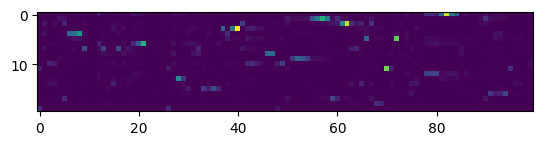

In [10]:
model_0 = LinearCorex(n_hidden=20, seed=42)
Y1_0 = model_0.fit_transform(crime.loc[indexes[0]])

print(model_0.tcs)
plt.imshow(model_0.mis)

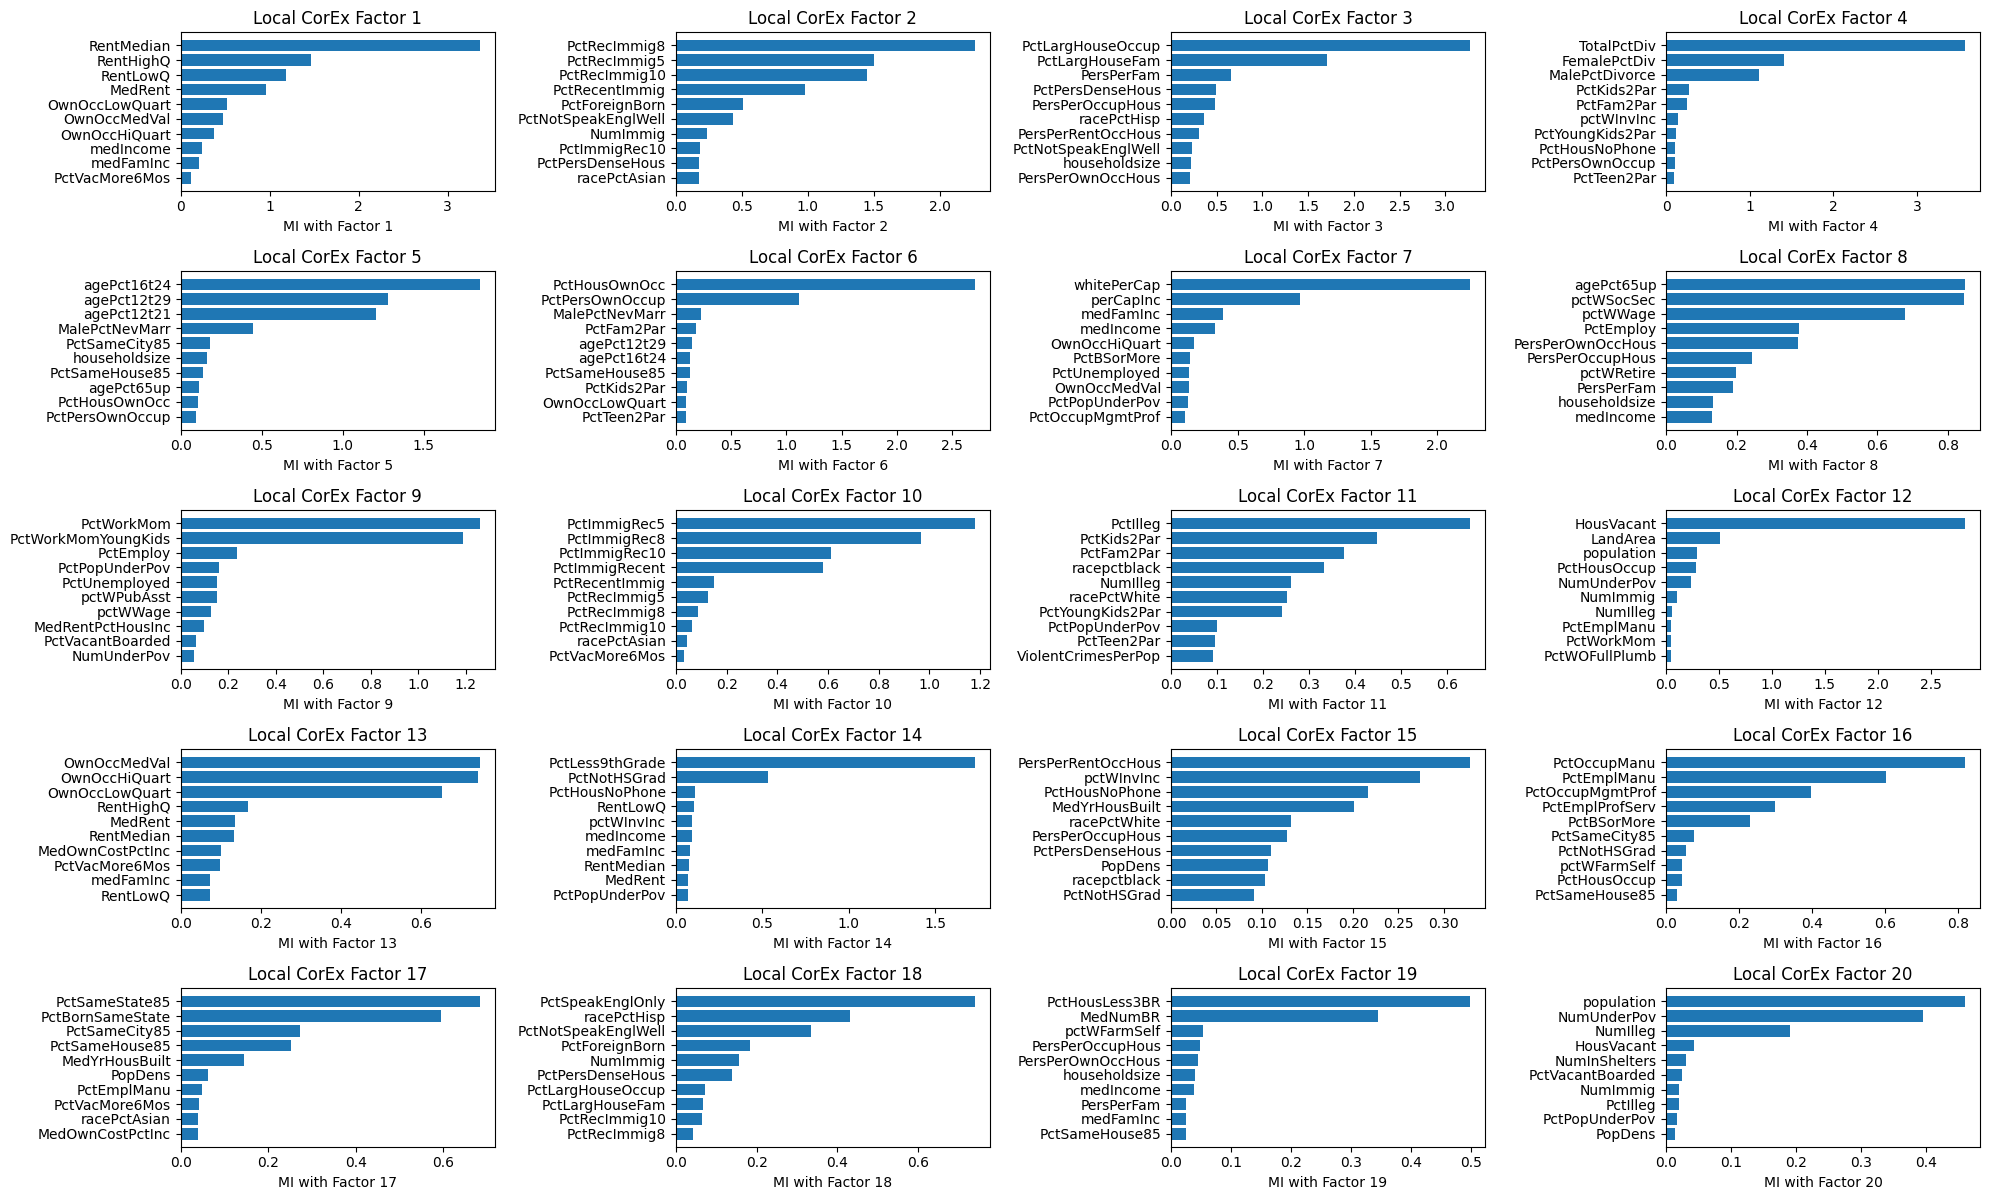

In [11]:
pu.plot_n_factors(model_0, crime, n=20, n_vals=10, cols=4) 

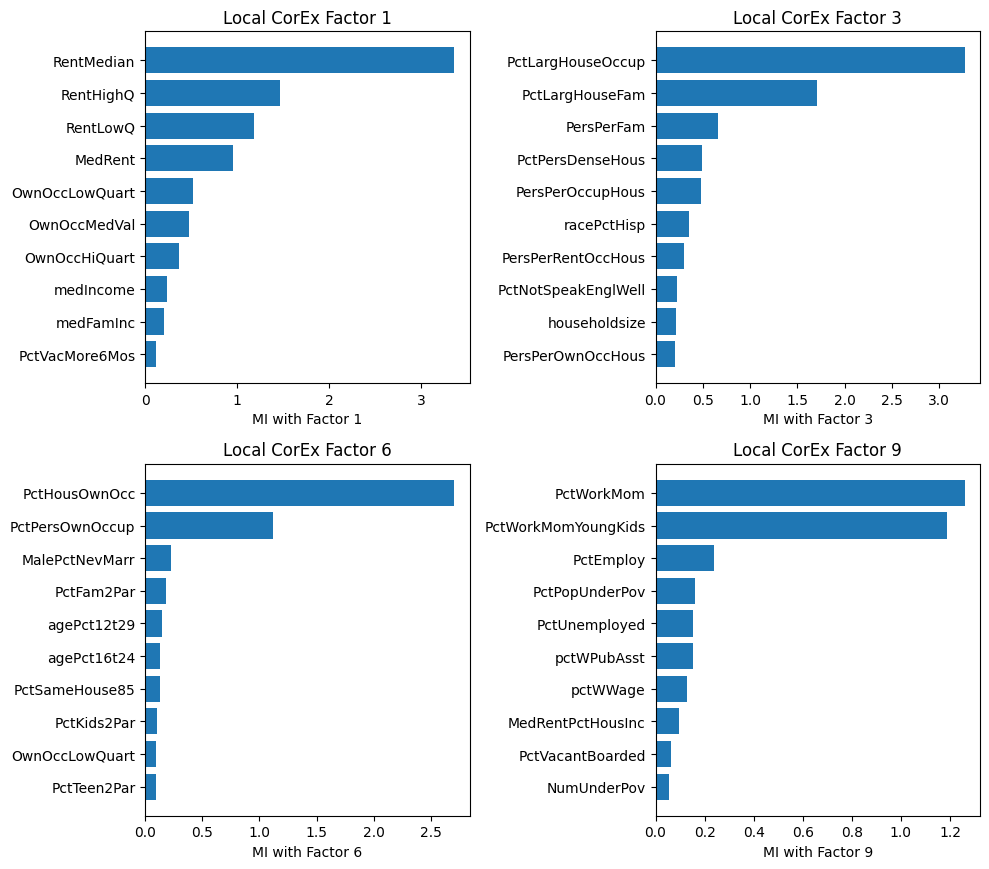

In [12]:
pu.plot_n_factors(model_0, crime, n=[0, 2, 5, 8], n_vals=10, cols=2)

### Group 9

In [13]:
du.explore_cluster(crime, indexes[9], 20)

PctSameState85          -0.923554
PctBornSameState        -0.821662
PctSameHouse85          -0.812170
PctSameCity85           -0.762973
pctUrban                 0.663705
MedYrHousBuilt           0.569482
PersPerFam              -0.568954
PctVacMore6Mos          -0.480766
PersPerOccupHous        -0.476644
PctLess9thGrade         -0.459825
PersPerOwnOccHous       -0.443523
householdsize           -0.442947
PctEmplManu             -0.440767
PctHousLess3BR           0.435959
PctNotHSGrad            -0.391688
PctWOFullPlumb          -0.370702
PctHousOccup            -0.368546
PctLargHouseOccup       -0.365710
MedOwnCostPctIncNoMtg   -0.363412
FemalePctDiv             0.361187
dtype: float64


[8.879496   8.827317   7.870931   7.4936447  6.835762   6.347706
 6.305853   5.4497957  5.3335633  2.696412   2.6961503  2.3674588
 2.345422   2.335298   2.1545303  1.7023442  1.6673245  1.4897646
 1.2011777  0.94622105]


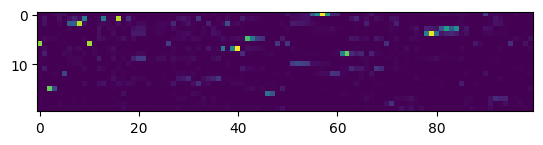

In [14]:
model_9 = LinearCorex(n_hidden=20, seed=42)
Y1_9 = model_9.fit_transform(crime.loc[indexes[9]])

print(model_9.tcs)
plt.imshow(model_9.mis)

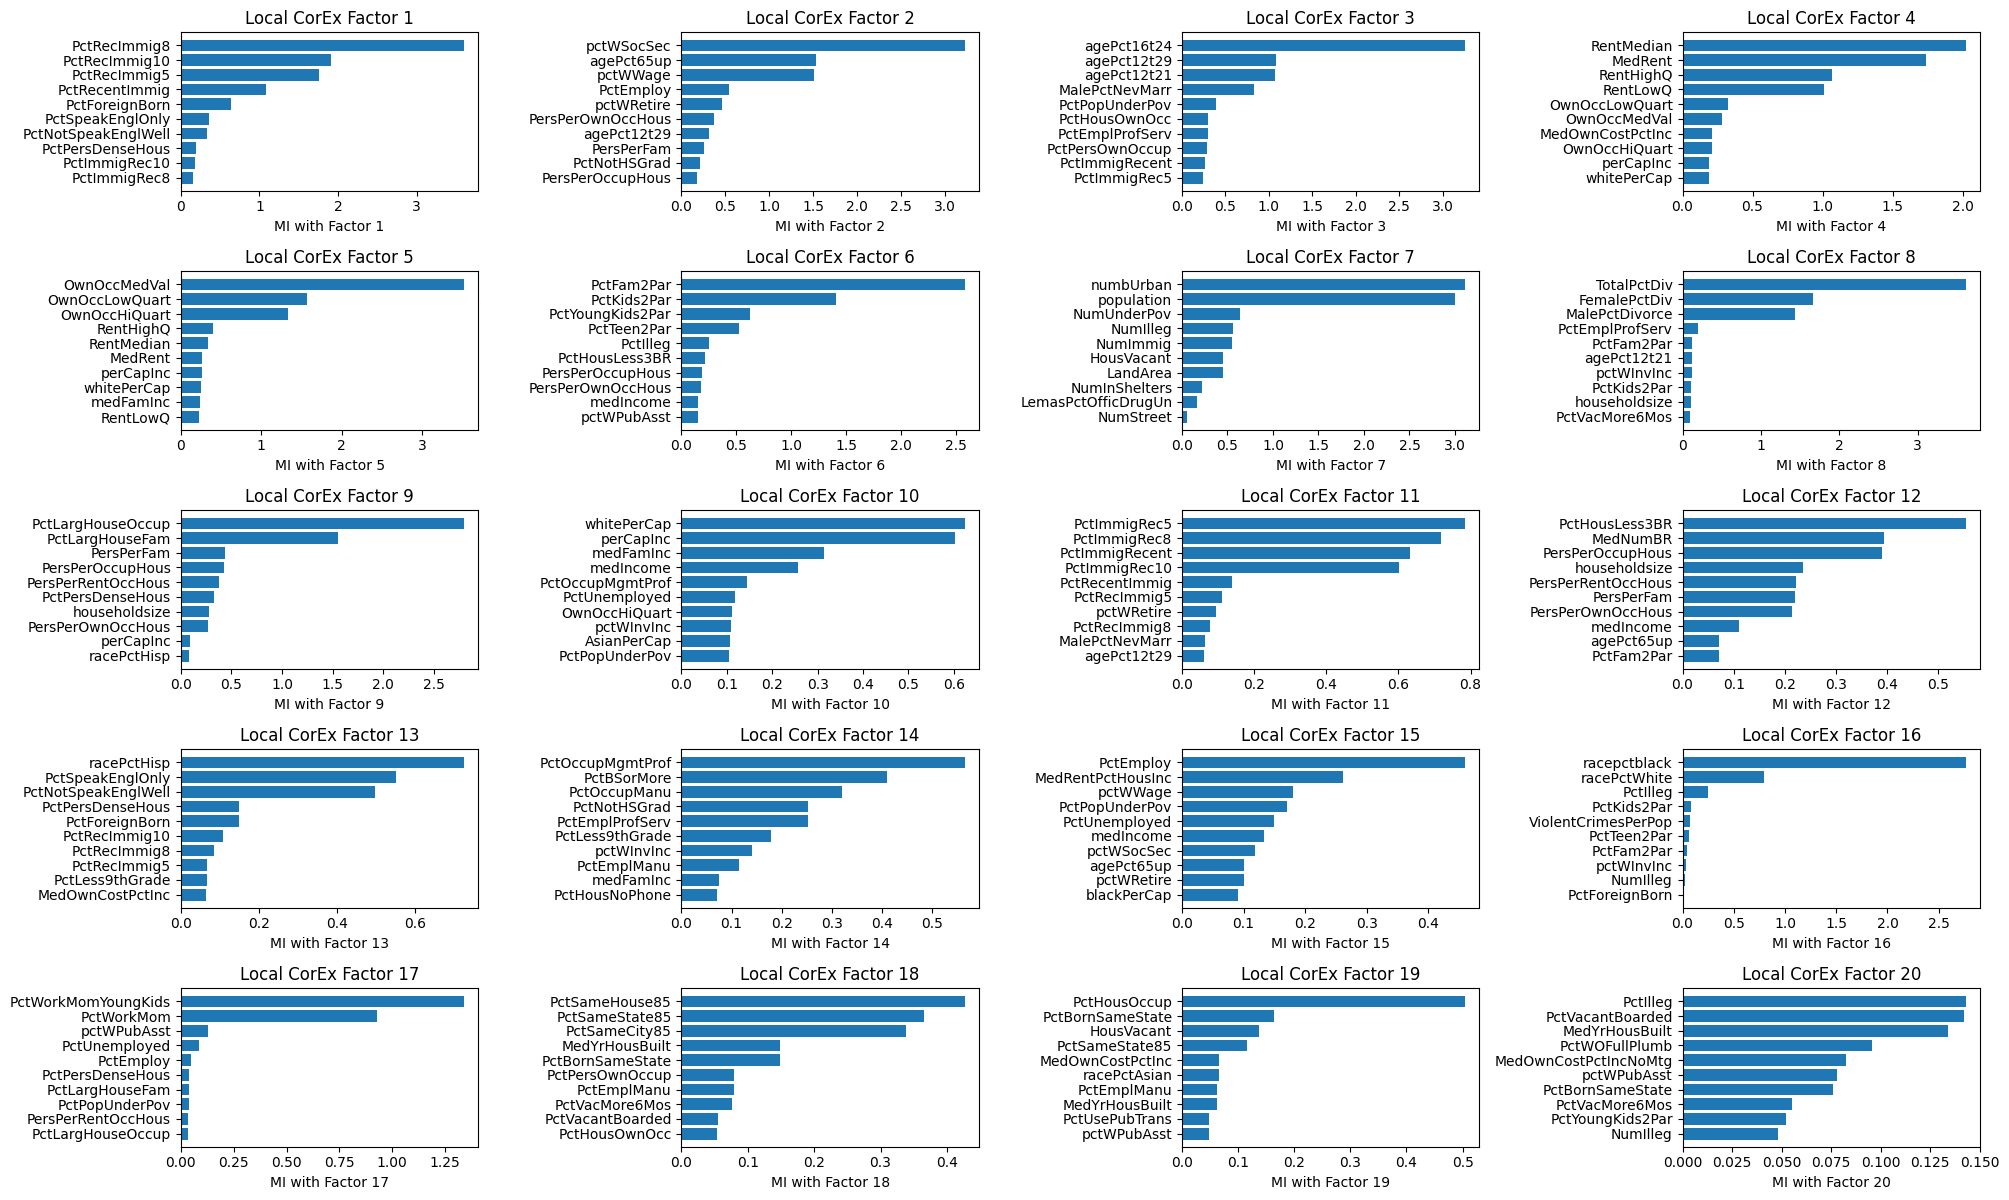

In [15]:
pu.plot_n_factors(model_9, crime, n=20, n_vals=10, cols=4) 

### Linear CorEx

Run on all data without partitioning

[15.166023   14.499679   13.058952    8.8582      7.68118     6.1080933
  4.716342    4.708304    3.9034908   3.4887989   3.0623965   2.8983955
  2.4132357   1.8611159   1.5215816   1.4949222   1.3341006   1.273742
  0.9195876   0.76705146]


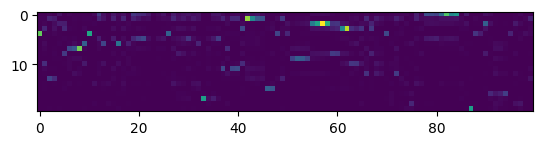

In [16]:
model_all = LinearCorex(n_hidden=20, seed=42)
Y1_0 = model_all.fit_transform(crime)

print(model_all.tcs)
plt.imshow(model_all.mis)

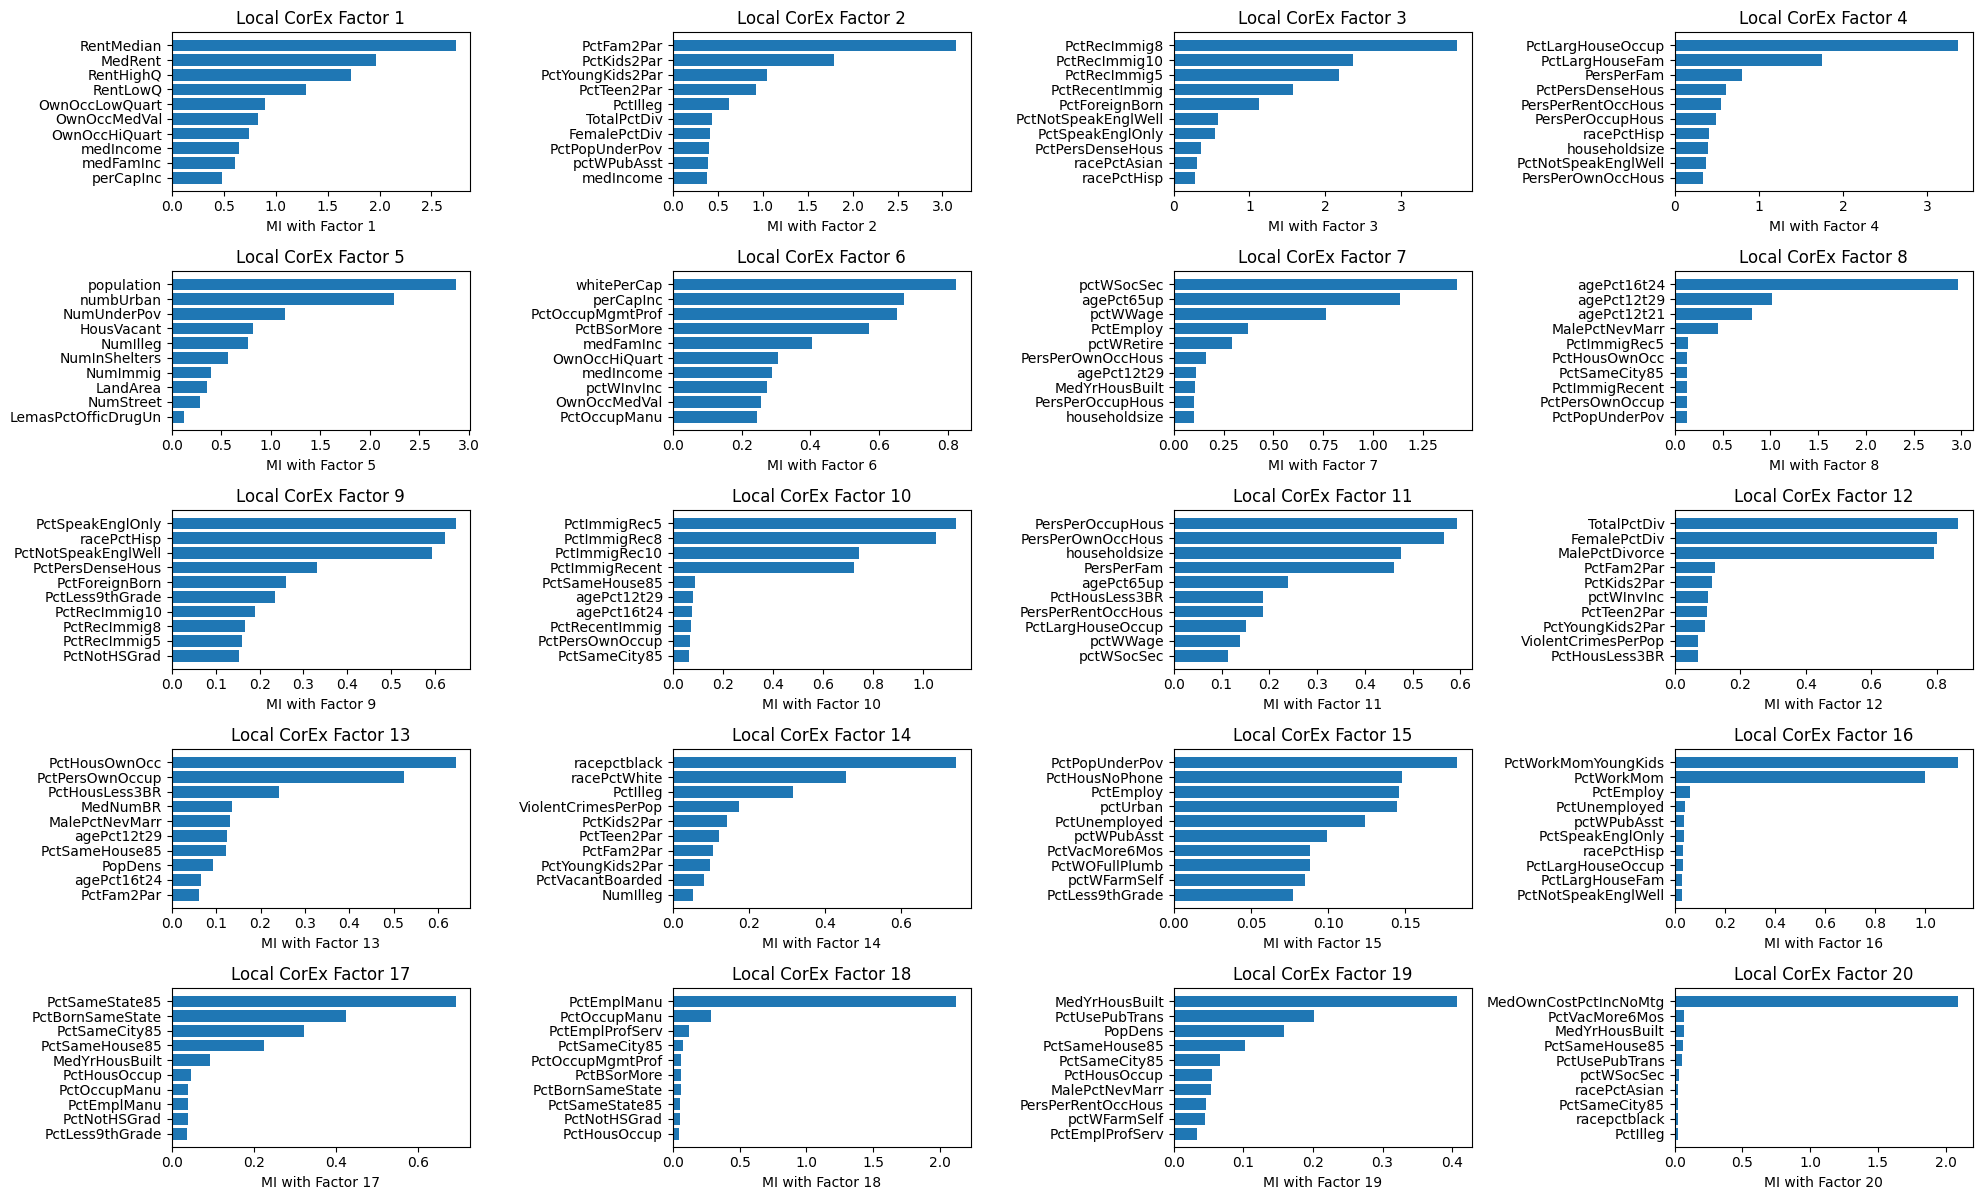

In [17]:
pu.plot_n_factors(model_all, crime, n=20, n_vals=10, cols=4) 

### Compare groups to one another

C:\Users\tkerby2\Desktop\Research\Local_CorEx\local_corex\utils\plotting.py:119: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


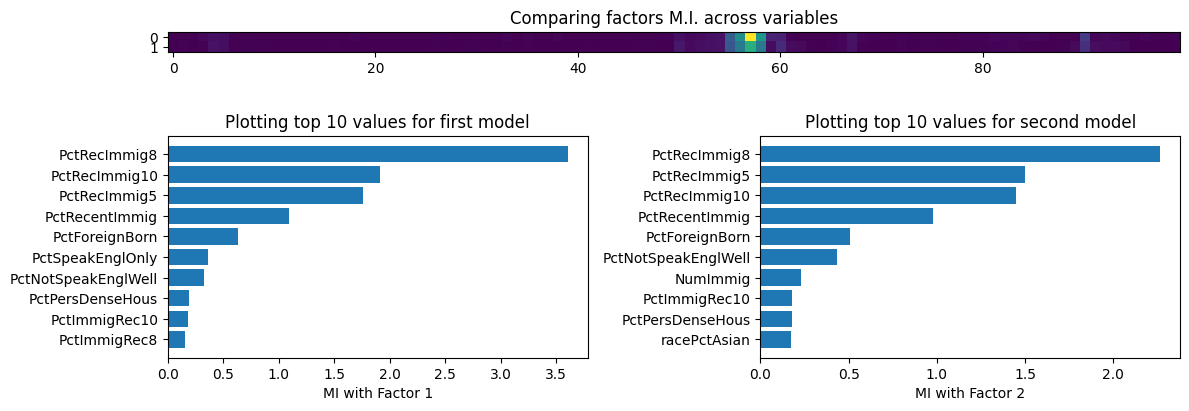

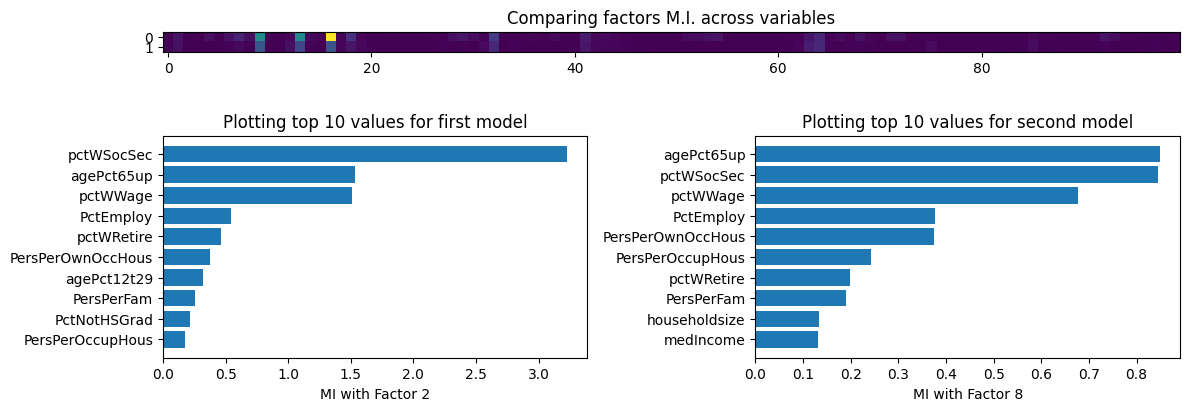

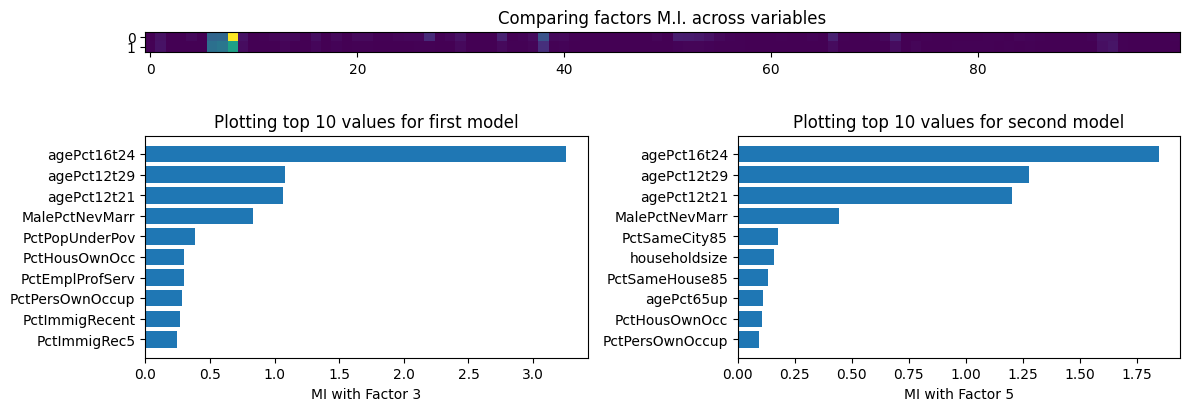

In [18]:
pu.vis_diff_between_partitions(crime, model_9, model_0, n_factors=3)

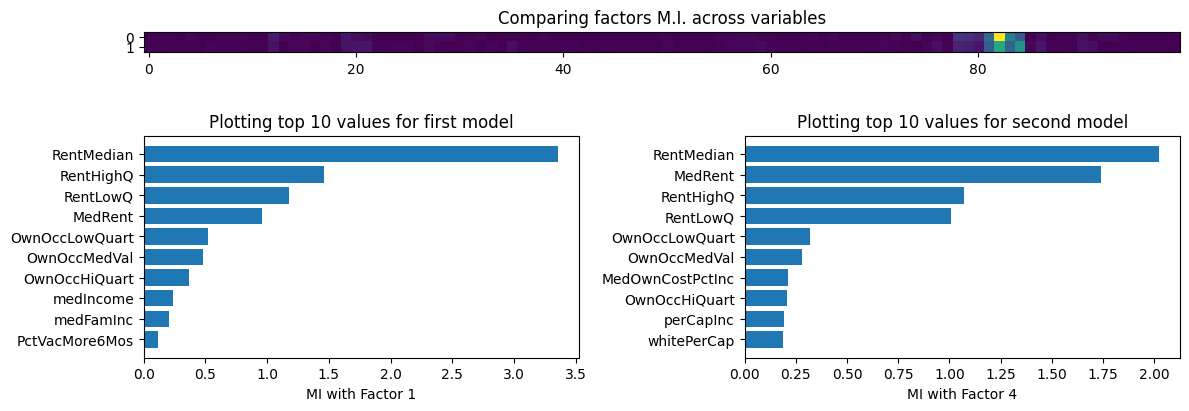

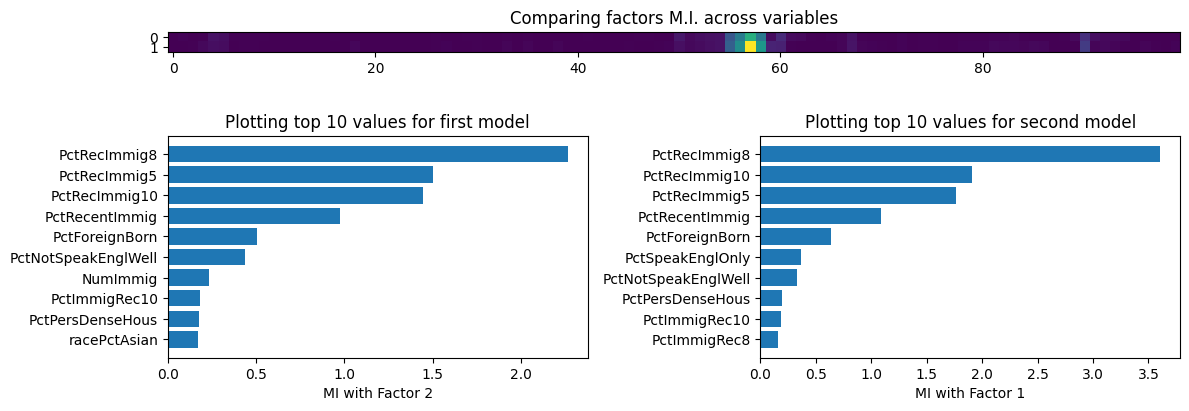

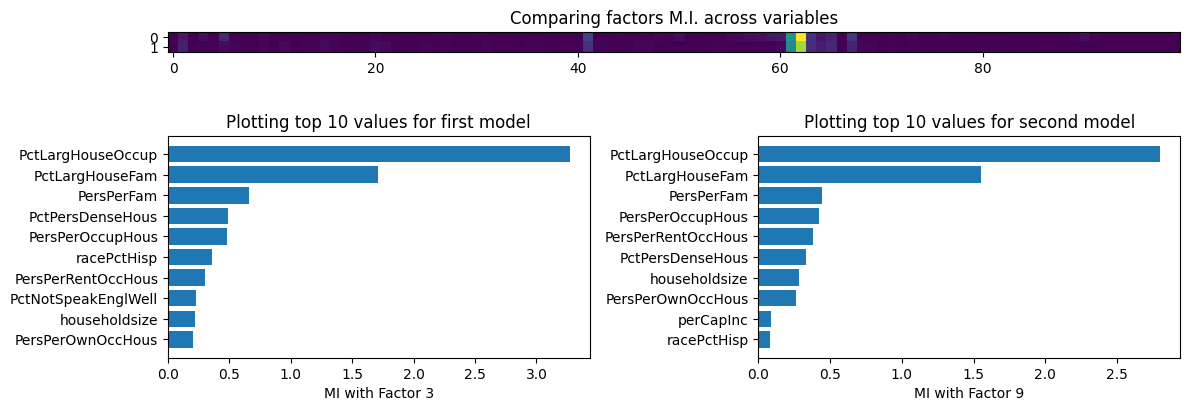

In [19]:
pu.vis_diff_between_partitions(crime, model_0, model_9, n_factors=3)

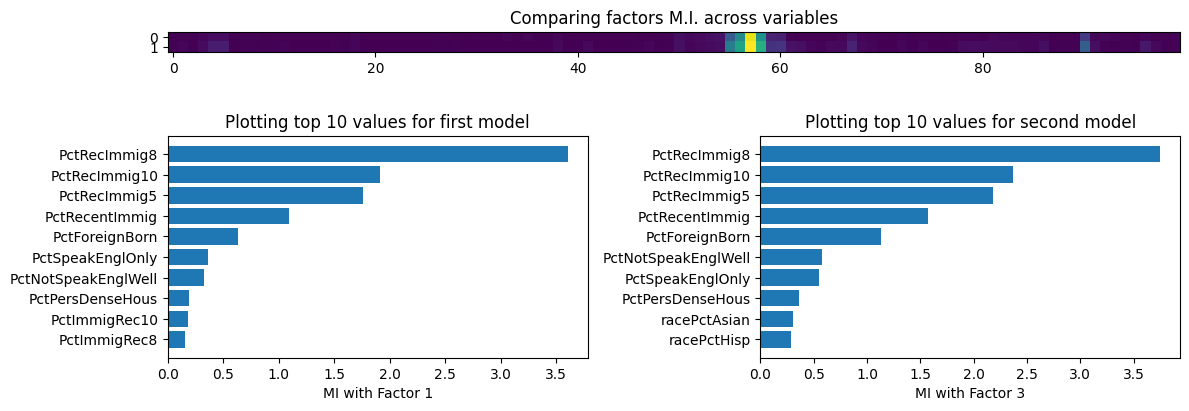

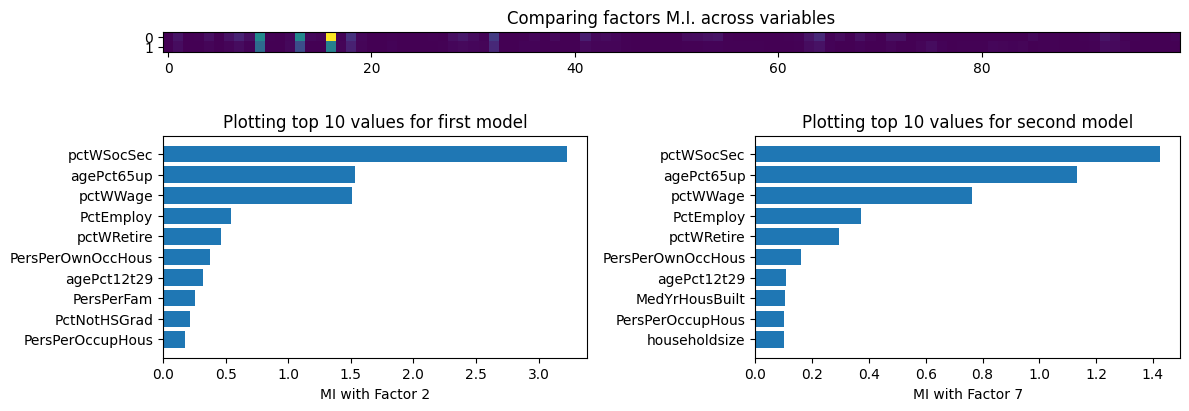

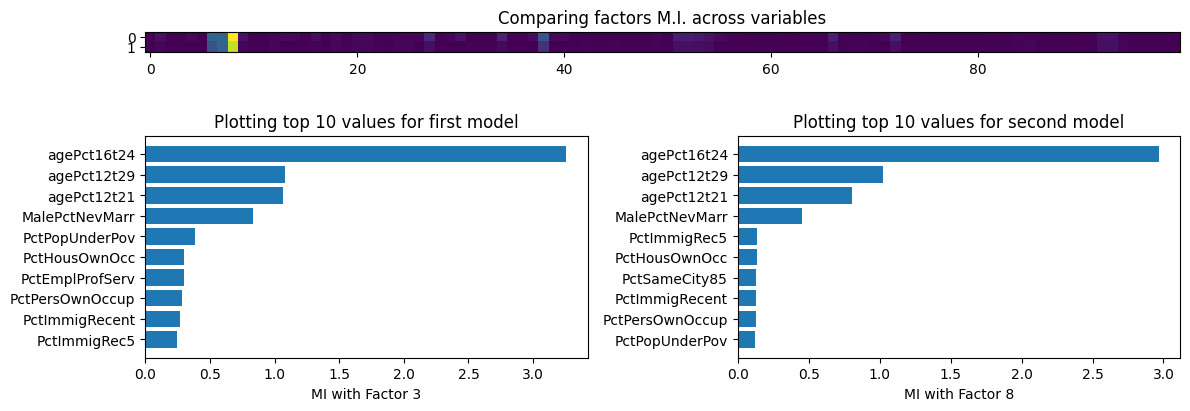

In [20]:
pu.vis_diff_between_partitions(crime, model_9, model_all, n_factors=3)

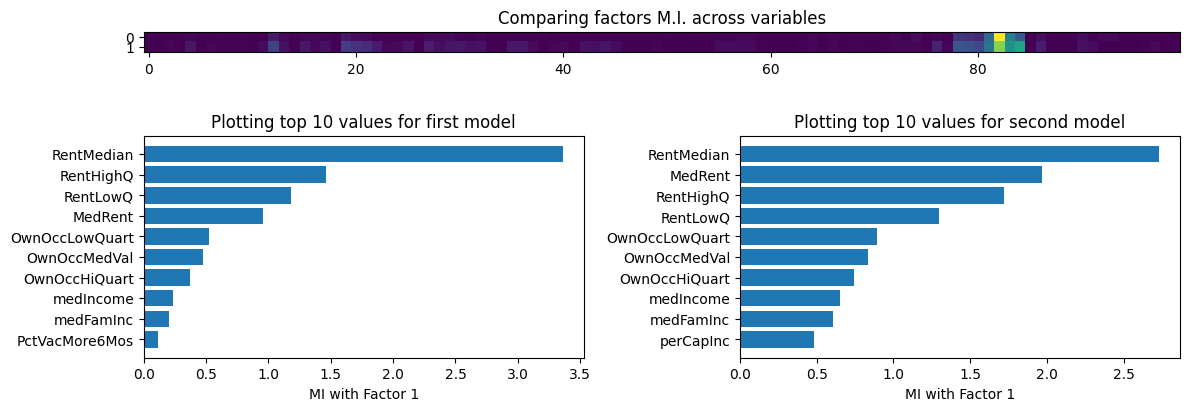

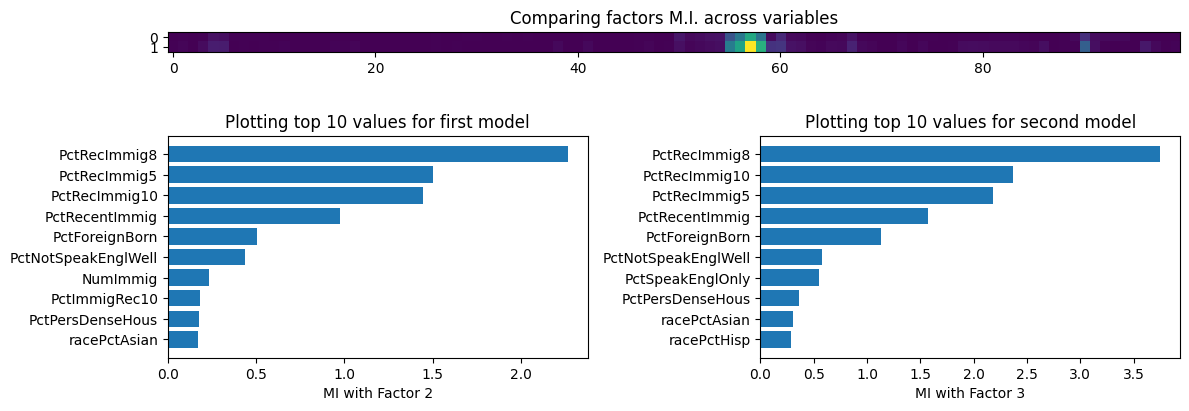

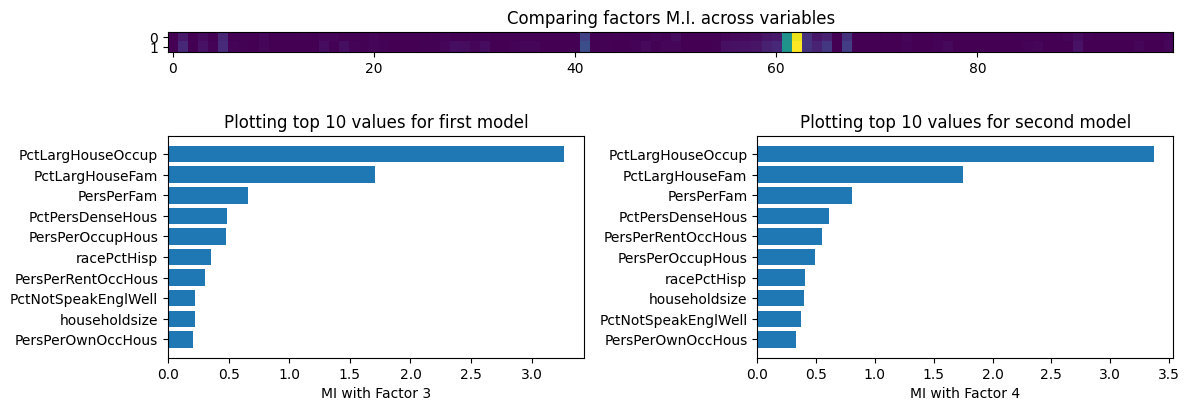

In [21]:
pu.vis_diff_between_partitions(crime, model_0, model_all, n_factors=3)

### Exercises & Exploration

1. **Adjust the Number of Clusters**: What happens when you increase or decrease the number of clusters in the KMeans partitioning step? How do the Local CorEx factors change as a result?
2. **Explore Other Variables**: In the `plot_corex_vars` function, try plotting factors for different clusters. What variables show the strongest mutual information in each partition?
3. **Compare Partitions**: Use the `vis_diff_between_partitions` function to compare Local CorEx models from different partitions. What can you infer from the differences between the top variables in each partition?